In [1]:
# !pip install opendatasets
# !pip install -q kaggle
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !pip install -U lightautoml==0.3.7.3

In [2]:
import sys
print(sys.version)

3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]


In [3]:
import torch
torch.cuda.is_available

<function torch.cuda.is_available() -> bool>

In [4]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from lightautoml.automl.presets.image_presets import TabularCVAutoML
from lightautoml.tasks import Task

In [5]:
INPUT_DIR = "../data/data_fer_bin/"

In [6]:
train_data = pd.read_csv("../data/data_fer_bin/lama_data_unique.csv")
print(train_data.shape)
train_data.head()

(25532, 2)


,label,image_id
0,negative,im1075sadness.png
1,negative,im2985fearful.png
2,negative,im100disgusted.png
3,negative,im1326fearful.png
4,negative,im3668fearful.png


In [7]:
submission = pd.read_csv("../data/data_fer_bin/lama_data_test_unique.csv")
print(submission.shape)
submission.head()

(6347, 2)


,label,image_id
0,negative,im1075sadness.png
1,negative,im100disgusted.png
2,negative,im19angry.png
3,negative,im78disgusted.png
4,negative,im655sadness.png


In [8]:
%%time

train_data['path'] = INPUT_DIR + 'train/' + train_data['label'] + '/' + train_data['image_id']
train_data.head()

CPU times: user 1.56 ms, sys: 4.93 ms, total: 6.49 ms
Wall time: 6.32 ms


,label,image_id,path
0,negative,im1075sadness.png,../data/data_fer_bin/train/negative/im1075sadn...
1,negative,im2985fearful.png,../data/data_fer_bin/train/negative/im2985fear...
2,negative,im100disgusted.png,../data/data_fer_bin/train/negative/im100disgu...
3,negative,im1326fearful.png,../data/data_fer_bin/train/negative/im1326fear...
4,negative,im3668fearful.png,../data/data_fer_bin/train/negative/im3668fear...


In [9]:
submission['path'] = INPUT_DIR + 'test/' + submission['label'] + '/' + submission['image_id']
submission.head()

,label,image_id,path
0,negative,im1075sadness.png,../data/data_fer_bin/test/negative/im1075sadne...
1,negative,im100disgusted.png,../data/data_fer_bin/test/negative/im100disgus...
2,negative,im19angry.png,../data/data_fer_bin/test/negative/im19angry.png
3,negative,im78disgusted.png,../data/data_fer_bin/test/negative/im78disgust...
4,negative,im655sadness.png,../data/data_fer_bin/test/negative/im655sadnes...


In [10]:
task = Task('multiclass')
roles = {
    'target': 'label',
    'path': ['path'],
    'group': 'image_id'
}

automl = TabularCVAutoML(task = task,
                         timeout= 5 * 3600,
                        cpu_limit = 8,
                        reader_params = {'cv': 5, 'random_state': 1})

In [11]:
%%time
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 3)

[06:16:30] Stdout logging level is INFO3.
[06:16:30] Task: multiclass

[06:16:30] Start automl preset with listed constraints:
[06:16:30] - time: 18000.00 seconds
[06:16:30] - CPU: 8 cores
[06:16:30] - memory: 16 GB

[06:16:30] Train data shape: (25532, 3)
[06:16:30] Layer 1 train process start. Time left 17999.95 secs
Loaded pretrained weights for efficientnet-b0
[06:16:31] Load saved dataset for path
[06:16:31] Feature path transformed
[06:16:32] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[06:16:32] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[06:16:33] Linear model: C = 1e-05 score = -0.782045323943201
[06:16:34] Linear model: C = 5e-05 score = -0.6895453815206303
[06:16:34] Linear model: C = 0.0001 score = -0.6595499787681108
[06:16:35] Linear model: C = 0.0005 score = -0.6170348364383338
[06:16:36] Linear model: C = 0.001 score = -0.6115461290119615
[06:16:37] Linear model: C = 0.005 score = -0.6237990318599017
[06:16:38] Linear model: C = 0.01 score =

In [12]:
preds = train_data[['image_id', 'label']]
preds

,image_id,label
0,im1075sadness.png,negative
1,im2985fearful.png,negative
2,im100disgusted.png,negative
3,im1326fearful.png,negative
4,im3668fearful.png,negative
...,...,...
25527,im3171.png,positive
25528,im6214.png,positive
25529,im3623.png,positive
25530,im6174.png,positive


In [13]:
for i in range(3):
    preds['pred_' + str(i)] = oof_pred.data[:,i]
    print(i)

preds

0
1
2


,image_id,label,pred_0,pred_1,pred_2
0,im1075sadness.png,negative,0.556561,0.229362,0.214077
1,im2985fearful.png,negative,0.822039,0.026711,0.151251
2,im100disgusted.png,negative,0.938801,0.017291,0.043908
3,im1326fearful.png,negative,0.927618,0.057045,0.015337
4,im3668fearful.png,negative,0.330168,0.251624,0.418209
...,...,...,...,...,...
25527,im3171.png,positive,0.160723,0.772609,0.066668
25528,im6214.png,positive,0.061121,0.919366,0.019512
25529,im3623.png,positive,0.047145,0.904301,0.048554
25530,im6174.png,positive,0.155338,0.737930,0.106732


In [14]:
preds = preds.groupby(['image_id', 'label']).mean().reset_index()
preds

,image_id,label,pred_0,pred_1,pred_2
0,im0.png,neutral,0.127134,0.023290,0.849577
1,im0.png,positive,0.289987,0.550906,0.159106
2,im0angry.png,negative,0.880671,0.016610,0.102719
3,im0disgusted.png,negative,0.685873,0.275425,0.038702
4,im0fearful.png,negative,0.939723,0.012418,0.047858
...,...,...,...,...,...
25527,im99sadness.png,negative,0.650687,0.105185,0.244128
25528,im9angry.png,negative,0.821001,0.051212,0.127787
25529,im9disgusted.png,negative,0.896077,0.060836,0.043087
25530,im9fearful.png,negative,0.631960,0.151731,0.216309


In [15]:
OOFs = np.argmax(preds[['pred_' + str(i) for i in range(3)]].values, axis = 1)
OOFs

array([2, 1, 0, ..., 0, 0, 0])

In [16]:
accuracy = (OOFs == preds['label'].map(automl.reader.class_mapping)).mean()
print(f'Out-of-fold accuracy: {accuracy}')

Out-of-fold accuracy: 0.7436550211499295


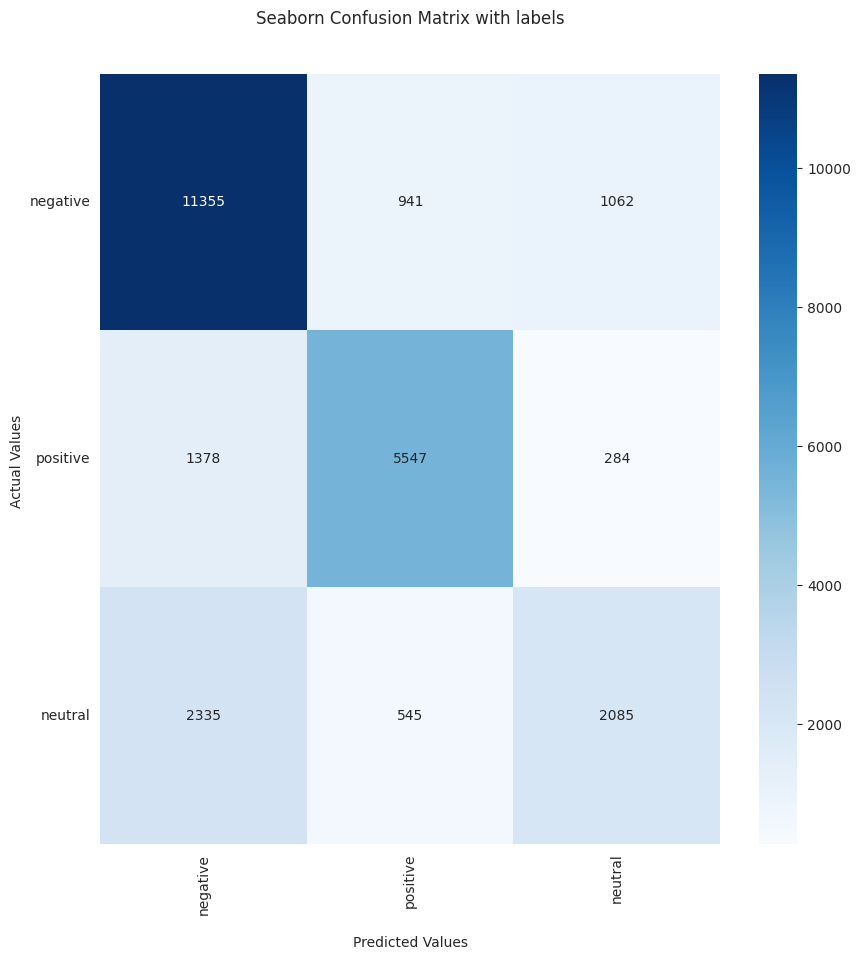

In [17]:
cf_matrix = confusion_matrix(preds['label'].map(automl.reader.class_mapping), OOFs)

plt.figure(figsize = (10, 10))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = 'd')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

inverse_class_mapping = {y: x for x,y in automl.reader.class_mapping.items()}
labels = [inverse_class_mapping[i] for i in range(len(inverse_class_mapping))]
ax.xaxis.set_ticklabels(labels, rotation = 90)
ax.yaxis.set_ticklabels(labels, rotation = 0)

plt.show()

In [18]:
%%time

te_pred = automl.predict(submission)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

[06:17:22] Load saved dataset for path
[06:17:22] Feature path transformed
Prediction for te_data:
array([[0.47635606, 0.01830839, 0.5053356 ],
       [0.68074626, 0.12773535, 0.19151844],
       [0.84892887, 0.10874201, 0.04232913],
       ...,
       [0.04358231, 0.94516563, 0.01125207],
       [0.6351377 , 0.12527725, 0.23958509],
       [0.0743985 , 0.8975686 , 0.02803294]], dtype=float32)
Shape = (6347, 3)
CPU times: user 2.87 s, sys: 179 ms, total: 3.05 s
Wall time: 727 ms


In [19]:
sub = submission[['image_id']]
for i in range(3):
    sub['pred_' + str(i)] = te_pred.data[:,i]

sub

/tmp/ipykernel_336957/2057777986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['pred_' + str(i)] = te_pred.data[:,i]


,image_id,pred_0,pred_1,pred_2
0,im1075sadness.png,0.476356,0.018308,0.505336
1,im100disgusted.png,0.680746,0.127735,0.191518
2,im19angry.png,0.848929,0.108742,0.042329
3,im78disgusted.png,0.819325,0.038376,0.142299
4,im655sadness.png,0.175569,0.027469,0.796962
...,...,...,...,...
6342,im199.png,0.729996,0.215025,0.054979
6343,im74.png,0.026840,0.949752,0.023408
6344,im284.png,0.043582,0.945166,0.011252
6345,im1013.png,0.635138,0.125277,0.239585


In [20]:
TEs = pd.Series(np.argmax(sub[['pred_' + str(i) for i in range(3)]].values, axis = 1)).map(inverse_class_mapping)
TEs

0        neutral
1       negative
2       negative
3       negative
4        neutral
          ...   
6342    negative
6343    positive
6344    positive
6345    negative
6346    positive
Length: 6347, dtype: object

In [21]:
sub['label'] = TEs
sub[['image_id', 'label']].to_csv('LightAutoML_TabularCVAutoML_with_aug.csv', index = False)
sub[['image_id', 'label']]

,image_id,label
0,im1075sadness.png,neutral
1,im100disgusted.png,negative
2,im19angry.png,negative
3,im78disgusted.png,negative
4,im655sadness.png,neutral
...,...,...
6342,im199.png,negative
6343,im74.png,positive
6344,im284.png,positive
6345,im1013.png,negative


In [22]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

f1_score(TEs, submission['label'], average="weighted")

0.7603124882226094

In [23]:
recall_score(TEs, submission['label'], average="weighted")

0.751693713565464

In [24]:
precision_score(TEs, submission['label'], average="weighted")

0.7763196369821322

In [25]:
import joblib

joblib.dump(automl, 'model_lama_fer.joblib')

['test_model.joblib']